In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ciciot2023-10sample/ciciot2023_10percent_sample.csv


In [3]:
import pandas as pd
# Specify the file path
file_path = '/kaggle/input/ciciot2023-10sample/ciciot2023_10percent_sample.csv'
dataset = pd.read_csv(file_path)

In [4]:
!pip install --upgrade scikit-learn==1.2.2
!pip install imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.5 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import collections
import os

# ========= Step 0: Clean NaN and infinite values =========
print("Checking for missing values...")
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
missing_total = dataset.isnull().sum().sum()
print(f"Missing values: {missing_total}")
dataset.dropna(inplace=True)

# ========= Step 1: Drop low-variance columns =========
print("Dropping low-variance columns...")
low_var_cols = [col for col in dataset.columns if dataset[col].nunique() <= 1]
dataset.drop(columns=low_var_cols, inplace=True)

# ========= Step 2: Encode labels =========
print("Encoding labels...")
le = LabelEncoder()
dataset['label'] = le.fit_transform(dataset['label'])

# ========= Step 3: Feature-label split =========
X = dataset.drop(columns=['label'])
y = dataset['label']

# ========= Step 4: Normalize features =========
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_df = pd.DataFrame(X_scaled)

# ========= Step 5: Drop highly correlated features (r > 0.95) =========
print("Removing highly correlated features...")
corr_matrix = X_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]
X_selected = X_df.drop(columns=to_drop).values
print(f"Features remaining: {X_selected.shape[1]}")

# ========= Step 6: Train-test split (80/20) =========
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# ========= Step 7: Labeled-Unlabeled split (20% labeled) =========
X_lab, X_unlab, y_lab, y_unlab = train_test_split(
    X_temp, y_temp, test_size=0.8, stratify=y_temp, random_state=42
)


Checking for missing values...
Missing values: 0
Dropping low-variance columns...
Encoding labels...
Scaling features...
Removing highly correlated features...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Features remaining: 31


In [6]:
# ========= Step 8: SMOTE Balancing =========
def apply_adaptive_smote(X, y, random_state=42):
    class_counts = collections.Counter(y)
    sampling_strategy = {}
    
    for class_id, count in class_counts.items():
        if count < 500:
            target = 1000
        elif count < 3000:
            target = min(3000, count * 3)
        elif count < 30000:
            target = min(15000, count * 2)
        else:
            continue  # skip large classes
        
        # Ensure requested target is strictly >= current count
        if target > count:
            sampling_strategy[class_id] = target

    print(f"Adaptive SMOTE strategy: {sampling_strategy}")
    
    if not sampling_strategy:
        print("No classes require SMOTE oversampling.")
        return X, y

    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state, k_neighbors=3)
    return smote.fit_resample(X, y)


import collections
from imblearn.over_sampling import BorderlineSMOTE, SMOTE

def apply_borderline_smote_limited(X, y, random_state=42):
    class_counts = collections.Counter(y)
    avg_target = 5000
    k_neighbors = 3

    borderline_classes = {}
    for cls, count in class_counts.items():
        if count < avg_target and count > k_neighbors:
            borderline_classes[cls] = avg_target

    print(f"Borderline SMOTE strategy: {borderline_classes}")

    X_res, y_res = X, y
    failed_classes = []

    # Try BorderlineSMOTE
    if borderline_classes:
        try:
            smote = BorderlineSMOTE(sampling_strategy=borderline_classes, random_state=random_state, k_neighbors=k_neighbors)
            X_res, y_res = smote.fit_resample(X_res, y_res)
        except ValueError as e:
            print(f"BorderlineSMOTE failed: {e}")

    # Check which classes still didn’t reach the target
    new_class_counts = collections.Counter(y_res)
    for cls, target in borderline_classes.items():
        if new_class_counts[cls] < target:
            failed_classes.append(cls)

    fallback_classes = {cls: avg_target for cls in failed_classes}
    print(f"Fallback to regular SMOTE for: {fallback_classes}")

    # Fallback SMOTE for failed classes
    if fallback_classes:
        try:
            smote = SMOTE(sampling_strategy=fallback_classes, random_state=random_state, k_neighbors=min(2, k_neighbors))
            X_res, y_res = smote.fit_resample(X_res, y_res)
        except ValueError as e:
            print(f"Fallback SMOTE failed: {e}")

    return X_res, y_res

print(f"Before SMOTE (Supervised): {collections.Counter(y_lab)}")
print(f"============================")
X_lab_supervised, y_lab_supervised = apply_adaptive_smote(X_lab, y_lab)
print(f"============================")
print(f"After Adaptive SMOTE: {collections.Counter(y_lab_supervised)}")
print(f"============================")
X_lab_mean_teacher, y_lab_mean_teacher = apply_borderline_smote_limited(X_lab, y_lab)
print(f"After Borderline SMOTE: {collections.Counter(y_lab_mean_teacher)}")

# ========= Step 9: Class Weights for supervised =========
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_lab_supervised), y=y_lab_supervised)
class_weight_dict = dict(zip(np.unique(y_lab_supervised), class_weights))


Before SMOTE (Supervised): Counter({6: 110936, 11: 71960, 9: 64724, 8: 61231, 10: 57570, 18: 49167, 17: 42743, 16: 32461, 1: 17570, 20: 15868, 22: 14248, 21: 12026, 7: 7240, 29: 5973, 19: 4921, 12: 4227, 4: 4196, 13: 2862, 23: 2150, 24: 1572, 26: 1316, 15: 1150, 5: 461, 14: 209, 2: 94, 3: 87, 27: 84, 30: 62, 0: 52, 25: 36, 28: 20})
Adaptive SMOTE strategy: {19: 9842, 22: 15000, 12: 8454, 26: 3000, 7: 14480, 13: 3000, 21: 15000, 29: 11946, 23: 3000, 4: 8392, 24: 3000, 14: 1000, 15: 3000, 30: 1000, 5: 1000, 2: 1000, 25: 1000, 0: 1000, 27: 1000, 3: 1000, 28: 1000}
After Adaptive SMOTE: Counter({6: 110936, 11: 71960, 9: 64724, 8: 61231, 10: 57570, 18: 49167, 17: 42743, 16: 32461, 1: 17570, 20: 15868, 22: 15000, 21: 15000, 7: 14480, 29: 11946, 19: 9842, 12: 8454, 4: 8392, 26: 3000, 13: 3000, 23: 3000, 24: 3000, 15: 3000, 14: 1000, 30: 1000, 5: 1000, 2: 1000, 25: 1000, 0: 1000, 27: 1000, 3: 1000, 28: 1000})
Borderline SMOTE strategy: {19: 5000, 12: 5000, 26: 5000, 13: 5000, 23: 5000, 4: 5000

# DNN on adaptive SMOTE

2025-07-16 14:59:29.447916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752677969.807097      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752677969.908413      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1752677987.388999      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752677987.389635      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/20


I0000 00:00:1752677991.115801     124 service.cc:148] XLA service 0x7c8588002920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752677991.117579     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752677991.117599     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752677991.422427     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752677993.248342     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1234/1234 - 12s - 10ms/step - accuracy: 0.7809 - loss: 0.5834 - val_accuracy: 0.8320 - val_loss: 0.3563
Epoch 2/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8084 - loss: 0.4312 - val_accuracy: 0.8360 - val_loss: 0.3433
Epoch 3/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8138 - loss: 0.4140 - val_accuracy: 0.8390 - val_loss: 0.3322
Epoch 4/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8182 - loss: 0.4025 - val_accuracy: 0.8419 - val_loss: 0.3275
Epoch 5/20
1234/1234 - 6s - 5ms/step - accuracy: 0.8217 - loss: 0.3948 - val_accuracy: 0.8431 - val_loss: 0.3235
Epoch 6/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8270 - loss: 0.3881 - val_accuracy: 0.8439 - val_loss: 0.3169
Epoch 7/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8346 - loss: 0.3789 - val_accuracy: 0.8607 - val_loss: 0.3042
Epoch 8/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8397 - loss: 0.3686 - val_accuracy: 0.8613 - val_loss: 0.2966
Epoch 9/20
1234/1234 - 5s - 4ms/step - accuracy: 0.8431 - loss: 0.3615 - val_accuracy: 0.8624 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        64
           1     0.7605    0.7990    0.7793     21963
           2     0.4615    0.1538    0.2308       117
           3     0.3898    0.2130    0.2754       108
           4     0.9952    0.9868    0.9910      5246
           5     0.8677    0.5920    0.7038       576
           6     1.0000    0.9989    0.9994    138670
           7     0.9538    0.9893    0.9712      9049
           8     0.9999    0.9962    0.9980     76540
           9     1.0000    0.9992    0.9996     80905
          10     0.7094    0.9682    0.8188     71963
          11     0.6473    0.9679    0.7757     89951
          12     0.9588    0.9898    0.9740      5284
          13     0.7185    0.2311    0.3498      3578
          14     0.7595    0.2299    0.3529       261
          15     0.7756    0.9596    0.8579      1437
          16     0.8382    0.2860    0.4265     40576
          17     0.6893    

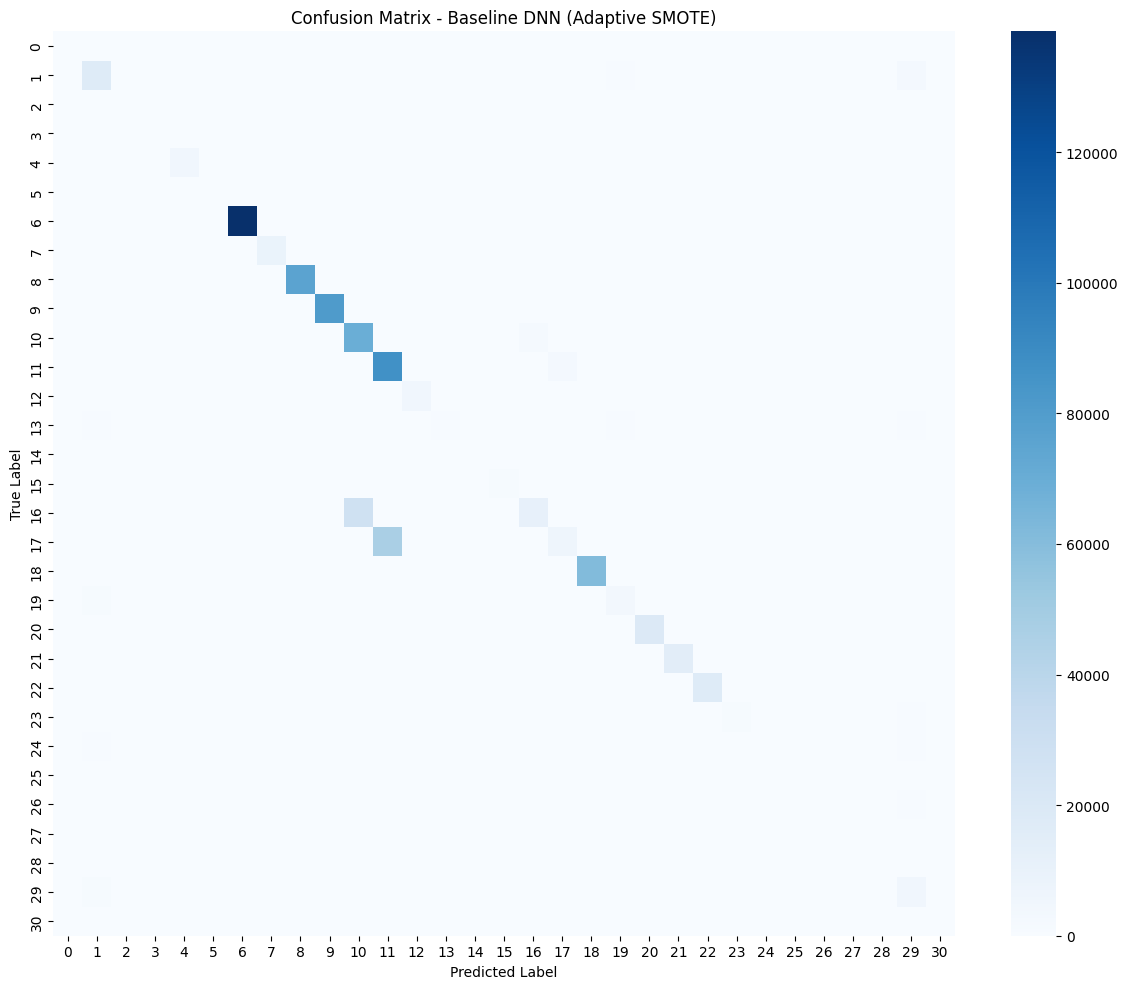

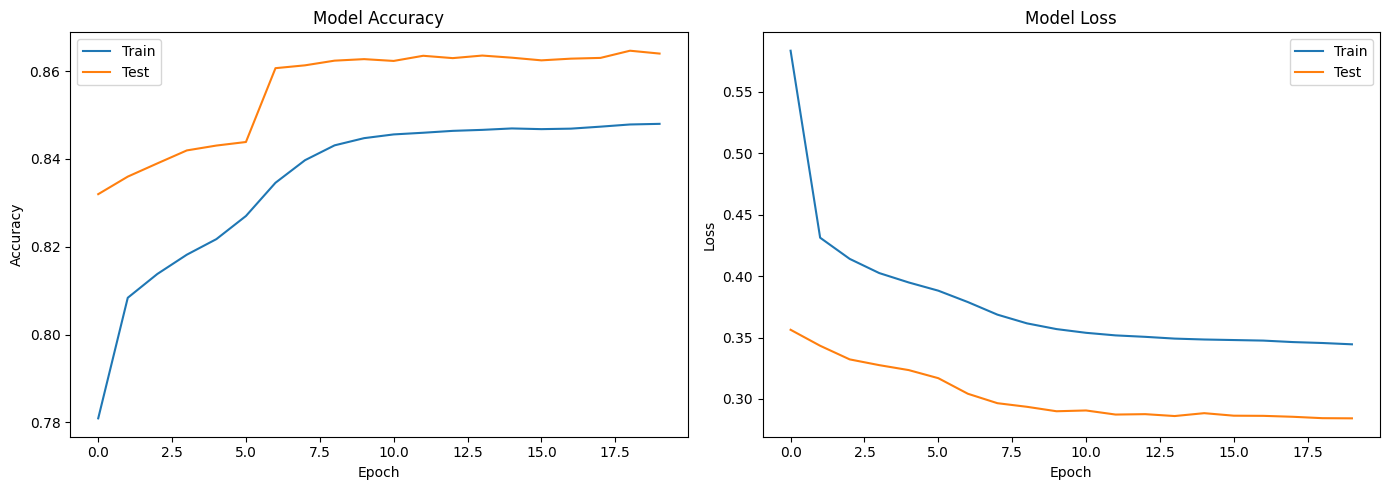

In [7]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Build baseline DNN model
def create_dnn_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Get number of classes and features
num_classes = len(np.unique(y_lab_supervised))
input_dim = X_lab_supervised.shape[1]

# Create and train the model
dnn_model = create_dnn_model(input_dim, num_classes)
history = dnn_model.fit(
    X_lab_supervised, y_lab_supervised,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=512,
    verbose=2
)

# Predict on test set
y_pred = np.argmax(dnn_model.predict(X_test), axis=1)

# Classification report
print("\n=== Classification Report (Baseline DNN with Adaptive SMOTE) ===")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Baseline DNN (Adaptive SMOTE)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot Training Accuracy and Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# DNN on Borderline SMOTE

Epoch 1/20
1268/1268 - 10s - 8ms/step - accuracy: 0.7609 - loss: 0.6505 - val_accuracy: 0.8195 - val_loss: 0.3727
Epoch 2/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8037 - loss: 0.4496 - val_accuracy: 0.8226 - val_loss: 0.3550
Epoch 3/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8124 - loss: 0.4181 - val_accuracy: 0.8252 - val_loss: 0.3451
Epoch 4/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8175 - loss: 0.4027 - val_accuracy: 0.8277 - val_loss: 0.3408
Epoch 5/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8204 - loss: 0.3918 - val_accuracy: 0.8282 - val_loss: 0.3382
Epoch 6/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8233 - loss: 0.3849 - val_accuracy: 0.8287 - val_loss: 0.3353
Epoch 7/20
1268/1268 - 6s - 4ms/step - accuracy: 0.8250 - loss: 0.3800 - val_accuracy: 0.8304 - val_loss: 0.3330
Epoch 8/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8264 - loss: 0.3770 - val_accuracy: 0.8309 - val_loss: 0.3315
Epoch 9/20
1268/1268 - 5s - 4ms/step - accuracy: 0.8276 - loss: 0.3727 - val_accuracy: 0.8415 -

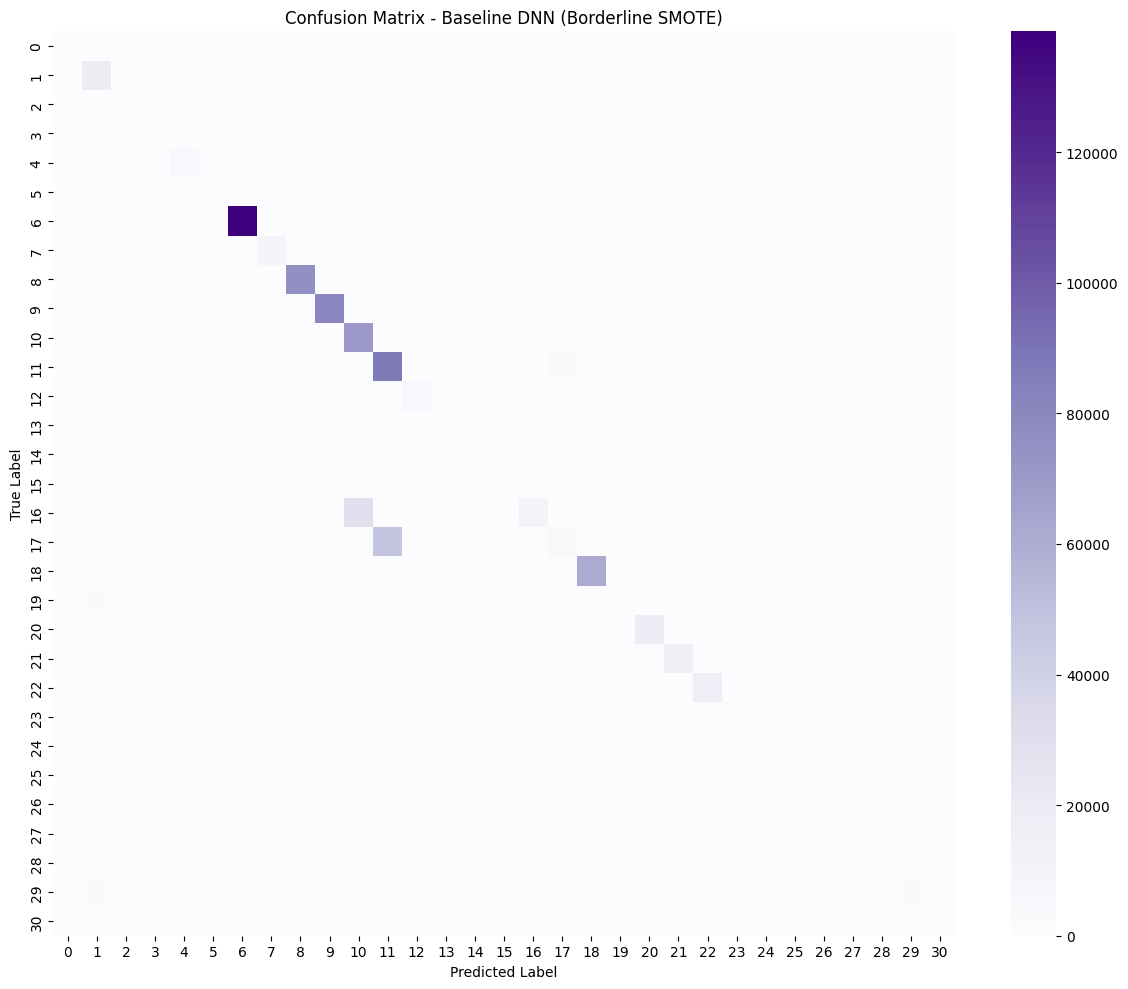

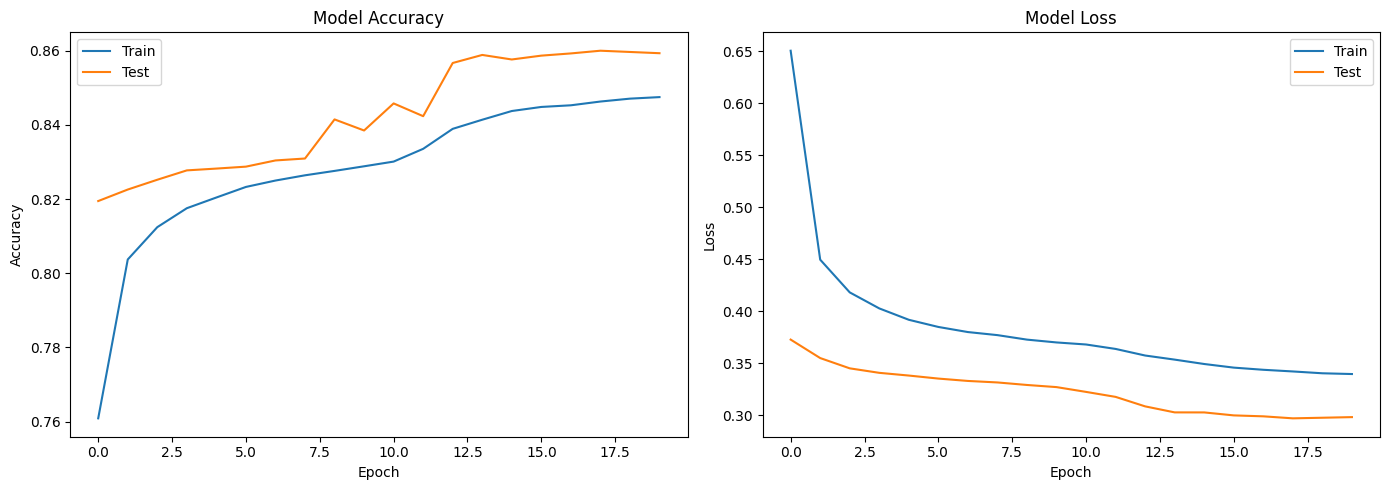

In [8]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Build DNN model
def create_dnn_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model parameters
num_classes = len(np.unique(y_lab_mean_teacher))
input_dim = X_lab_mean_teacher.shape[1]

# Initialize and train model
dnn_model_borderline = create_dnn_model(input_dim, num_classes)
history_borderline = dnn_model_borderline.fit(
    X_lab_mean_teacher, y_lab_mean_teacher,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=512,
    verbose=2
)

# Predict on test set
y_pred_borderline = np.argmax(dnn_model_borderline.predict(X_test), axis=1)

# Metrics
print("\n=== Classification Report (Baseline DNN with Borderline SMOTE) ===")
print(classification_report(y_test, y_pred_borderline, digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_borderline)
sns.heatmap(cm, annot=False, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Baseline DNN (Borderline SMOTE)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Accuracy and Loss Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_borderline.history['accuracy'], label='Train')
plt.plot(history_borderline.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_borderline.history['loss'], label='Train')
plt.plot(history_borderline.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
